<a href="https://colab.research.google.com/github/cbarron100/Neural-Networks/blob/main/image_classification_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is am image processesing Neural Network that will classify the a set of images as Normal, Covid or Pneumonia. This will be difficult.

The images are organised in Training and Testing sets. They are in files that correspond to their classification. This means that this is a multi-classification problem.

The images themselves are grayscale, this will be important later.

Let's gooo!!!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First thing is first, we need to preprocess the images. Let's make an ImageGenerator object to prepare the images through the Neural Network.

When looking at the properties of the images we see that the width X height is 256 X 256. We will scale out images to 1.0/256 and we will also augment them by zooming, rotating, fliping and shifting (height and width) randomely.

We have an ImageGenerator object for the validation set as well, but this does not augmenting in anyway since they will be the test set. This means that we only need to rescale the image values.

In [58]:
training_data_generator = ImageDataGenerator(rescale = 1.0/256,
                                             zoom_range = 0.3,
                                             rotation_range = 30,
                                             width_shift_range = 0.1,
                                             height_shift_range = 0.1,
                                             vertical_flip = True,
                                             horizontal_flip = True)

test_data_generator = ImageDataGenerator(rescale = 1.0/255)

#print(training_data_generator.__dict__)
location_train = '/content/drive/MyDrive/Covid19-dataset/train'
location_test = '/content/drive/MyDrive/Covid19-dataset/test'
id_mode = 'categorical'
colour_mode = 'grayscale'
t_size = (256, 256)
batch = 32

training_iterator = training_data_generator.flow_from_directory(directory= location_train,
                                                                target_size= t_size,
                                                                class_mode = id_mode,
                                                                color_mode = colour_mode,
                                                                shuffle=True)
training_iterator.next()
testing_iterator = test_data_generator.flow_from_directory(directory= location_test,
                                                           target_size= t_size,
                                                           class_mode = id_mode,
                                                           color_mode = colour_mode,
                                                           shuffle=True)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


We are now going to create the model structure. We have to have an input layer of 256 by 256 due to the image sizes.


We will start by not adding any convulution and see what happens to out model summary. To begin with we have a flatten layer, Dense layer of 50 inputs with ReLU activation and an output of 3. The output layer has softmax activation. This strucutre create a model that has 3277003 parameters. That is too many!!! Let's make some adjustments.


In [40]:
model = Sequential()
model.add(keras.Input(shape = (256, 256, 1))) # 1 specifies the grayscale
model.add(keras.layers.Flatten()) # makes an array 256x256 long
model.add(keras.layers.Dense(50, activation = 'relu'))
model.add(keras.layers.Dense(3, activation = 'softmax')) # this is out output

model_summary = model.summary()

print(model_summary)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 65536)             0         
                                                                 
 dense_32 (Dense)            (None, 50)                3276850   
                                                                 
 dense_33 (Dense)            (None, 3)                 153       
                                                                 
Total params: 3277003 (12.50 MB)
Trainable params: 3277003 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


We are going to add some Convolution layers to our model. We can start with a filter of 3x3 and since we are processing Grayscale images we will only need 1 channel. We will set the activation to ReLU. After adding this layer we have a model that has 263 trainable parameters. Still a lot, we can maybe add another.

After adding more convolution layers we get a more detailed network, that could be ready for testing. We have ended up with a model that has 3 convolution layers that start with larger filter sizes and more filters and decrease from 8 filters to 2. Then also from filter size 5 to 3..This results in a model that has 91001 trainable parameters.

In [41]:
model_conv = Sequential()
model_conv.add(keras.Input(shape = (256, 256, 1))) # 1 specifies the grayscale

model_conv.add(keras.layers.Conv2D(8, 5, activation = 'relu', padding = 'same', strides = 4))
model_conv.add(keras.layers.Conv2D(4, 4, activation = 'relu', padding = 'same', strides = 2))
model_conv.add(keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'valid', strides = 1))

model_conv.add(keras.layers.Flatten())

model_conv.add(keras.layers.Dense(50, activation = 'relu'))
model_conv.add(keras.layers.Dense(3, activation = 'softmax')) # this is out output

model_conv_summary = model_conv.summary()

print(model_conv_summary)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 64, 64, 8)         208       
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 4)         516       
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 2)         74        
                                                                 
 flatten_16 (Flatten)        (None, 1800)              0         
                                                                 
 dense_34 (Dense)            (None, 50)                90050     
                                                                 
 dense_35 (Dense)            (None, 3)                 153       
                                                                 
Total params: 91001 (355.47 KB)
Trainable params: 9100

Since we still have a large number of paramters, adding a pooling layer will lower the number of parameters. Therefore, we shall had a polling layer at the end of the convolution layers to reduce the parameters. This layer will have a pooling of size 3 and stride of 3 as well. Futher, it will have padding of valid.

This resulted in a model that had 11001 trainable parameters.

In [42]:
model_conv_pooling = Sequential()
model_conv_pooling.add(keras.Input(shape = (256, 256, 1))) # 1 specifies the grayscale

model_conv_pooling.add(keras.layers.Conv2D(8, 5, activation = 'relu', padding = 'same', strides = 4))
model_conv_pooling.add(keras.layers.Conv2D(4, 4, activation = 'relu', padding = 'same', strides = 2))
model_conv_pooling.add(keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'valid', strides = 1))

model_conv_pooling.add(keras.layers.MaxPooling2D(pool_size = (3, 3), strides = 3, padding = 'valid'))

model_conv_pooling.add(keras.layers.Flatten())

model_conv_pooling.add(keras.layers.Dense(50, activation = 'relu'))
model_conv_pooling.add(keras.layers.Dense(3, activation = 'softmax')) # this is out output

model_conv_pooling_summary = model_conv_pooling.summary()

print(model_conv_pooling_summary)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 64, 64, 8)         208       
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 4)         516       
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 30, 2)         74        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 2)         0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 200)               0         
                                                                 
 dense_36 (Dense)            (None, 50)                10050     
                                                      

We now need to make an optimiser and add it to our model.

We will be using Adam, but we could use SDG  or others with a learning rate of 0.005. We will need to use Categorical Cross entropy since we have categorical data. We will want to know the realtionship between false positives and true positives so we will be using AUC metric.

We will ba adding this to all the models we have created. But to save on processeing we will test each model seperately.

We started with a batch size of 16 but because it ran out of data for this size we had to increase the value to smake the steps per epoch smaller.


In [67]:
optim  = keras.optimizers.Adam(learning_rate=0.005)
Loss = keras.losses.CategoricalCrossentropy()
met = [keras.metrics.CategoricalAccuracy(), keras.metrics.AUC()]
BATCH_SIZE = 32
EPOCHS = 10

In [63]:
model.compile(optimizer=optim, loss = Loss, metrics = met)
model_history = model.fit(training_iterator,
                          steps_per_epoch=training_iterator.samples/BATCH_SIZE,
                          epochs = EPOCHS,
                          validation_data = testing_iterator,
                          validation_steps = testing_iterator.samples/BATCH_SIZE
                          )

Epoch 1/5
7/7 [==============================] - 6s 637ms/step - loss: 1.0859 - categorical_accuracy: 0.4422 - auc_8: 0.5769 - val_loss: 1.0916 - val_categorical_accuracy: 0.3939 - val_auc_8: 0.5455
Epoch 2/5
7/7 [==============================] - 4s 591ms/step - loss: 1.0816 - categorical_accuracy: 0.4422 - auc_8: 0.5815 - val_loss: 1.0908 - val_categorical_accuracy: 0.3939 - val_auc_8: 0.5455
Epoch 3/5
7/7 [==============================] - 5s 716ms/step - loss: 1.0795 - categorical_accuracy: 0.4422 - auc_8: 0.5703 - val_loss: 1.0907 - val_categorical_accuracy: 0.3939 - val_auc_8: 0.5455
Epoch 4/5
7/7 [==============================] - 4s 548ms/step - loss: 1.0769 - categorical_accuracy: 0.4422 - auc_8: 0.5850 - val_loss: 1.0908 - val_categorical_accuracy: 0.3939 - val_auc_8: 0.5455
Epoch 5/5
7/7 [==============================] - 5s 655ms/step - loss: 1.0758 - categorical_accuracy: 0.4422 - auc_8: 0.5851 - val_loss: 1.0911 - val_categorical_accuracy: 0.3939 - val_auc_8: 0.5455


In [66]:
model_conv.compile(optimizer=optim, loss = Loss, metrics = met)
model_conv_history = model_conv.fit(training_iterator,
                                    steps_per_epoch=training_iterator.samples/BATCH_SIZE,
                                    epochs = EPOCHS,
                                    validation_data = testing_iterator,
                                    validation_steps = testing_iterator.samples/BATCH_SIZE
                                    )

Epoch 1/5
7/7 [==============================] - 9s 1s/step - loss: 1.0267 - categorical_accuracy: 0.5179 - auc_9: 0.6648 - val_loss: 0.8945 - val_categorical_accuracy: 0.6515 - val_auc_9: 0.7647
Epoch 2/5
7/7 [==============================] - 5s 653ms/step - loss: 0.9129 - categorical_accuracy: 0.5618 - auc_9: 0.7565 - val_loss: 0.6386 - val_categorical_accuracy: 0.8333 - val_auc_9: 0.9400
Epoch 3/5
7/7 [==============================] - 6s 845ms/step - loss: 0.8484 - categorical_accuracy: 0.6215 - auc_9: 0.7945 - val_loss: 0.5534 - val_categorical_accuracy: 0.7576 - val_auc_9: 0.9254
Epoch 4/5
7/7 [==============================] - 5s 620ms/step - loss: 0.7439 - categorical_accuracy: 0.6813 - auc_9: 0.8464 - val_loss: 0.5001 - val_categorical_accuracy: 0.8485 - val_auc_9: 0.9792
Epoch 5/5
7/7 [==============================] - 6s 726ms/step - loss: 0.7444 - categorical_accuracy: 0.6494 - auc_9: 0.8422 - val_loss: 0.4772 - val_categorical_accuracy: 0.8333 - val_auc_9: 0.9605


In [68]:
model_conv_pooling.compile(optimizer=optim, loss = Loss, metrics = met)
model_conv_pooling_history = model_conv_pooling.fit(training_iterator,
                                                      steps_per_epoch=training_iterator.samples/BATCH_SIZE,
                                                      epochs = EPOCHS,
                                                      validation_data = testing_iterator,
                                                      validation_steps = testing_iterator.samples/BATCH_SIZE
                                                      )

Epoch 1/5
7/7 [==============================] - 9s 725ms/step - loss: 0.8688 - categorical_accuracy: 0.6056 - auc_10: 0.7852 - val_loss: 0.6443 - val_categorical_accuracy: 0.8030 - val_auc_10: 0.9224
Epoch 2/5
7/7 [==============================] - 6s 773ms/step - loss: 0.7793 - categorical_accuracy: 0.6375 - auc_10: 0.8316 - val_loss: 0.6782 - val_categorical_accuracy: 0.7424 - val_auc_10: 0.9065
Epoch 3/5
7/7 [==============================] - 6s 824ms/step - loss: 0.7685 - categorical_accuracy: 0.6295 - auc_10: 0.8327 - val_loss: 0.7147 - val_categorical_accuracy: 0.6515 - val_auc_10: 0.8584
Epoch 4/5
7/7 [==============================] - 7s 897ms/step - loss: 0.7519 - categorical_accuracy: 0.6693 - auc_10: 0.8399 - val_loss: 0.5694 - val_categorical_accuracy: 0.7727 - val_auc_10: 0.9198
Epoch 5/5
7/7 [==============================] - 8s 1s/step - loss: 0.7497 - categorical_accuracy: 0.6574 - auc_10: 0.8426 - val_loss: 0.6985 - val_categorical_accuracy: 0.6061 - val_auc_10: 0.850

After the first test with three models one simple model with nothing special, another with convolution, and a thrid with pooling there are some interesting results.

First let's intorduce some changes we had to make. The batch size had to be increased due to there not being enough data per epoch step. It is now at 32 and that seems to be suitable with the data that we have. Next we have accuracies that are interesting. These are recorded in the figures below.



Below is a figure showing the training and validation accuracy and auc over the epochs for the basic model.

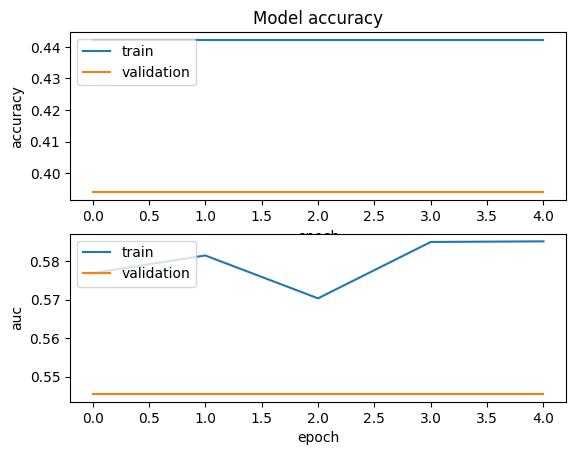

In [74]:
fig = plt.figure()
#plot the accuracy over the epochs
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(model_history.history['categorical_accuracy'])
ax1.plot(model_history.history['val_categorical_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(model_history.history['auc_8'])
ax2.plot(model_history.history['val_auc_8'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
fig.savefig('/content/drive/MyDrive/model_1_accuracy.png')


Below is a figure showing the training and validation accuracy and auc over the epochs for the model with the convolution layers





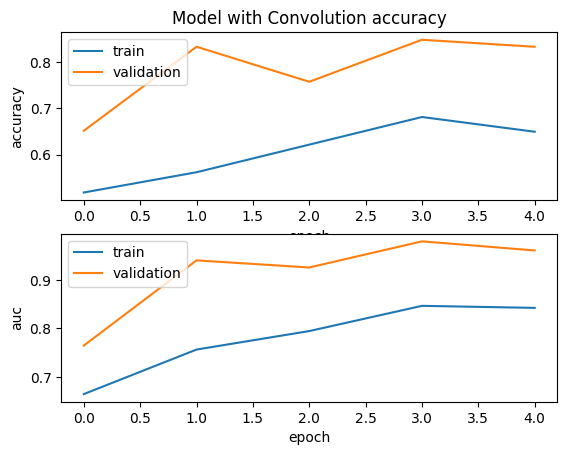

In [76]:
fig = plt.figure()
#plot the accuracy over the epochs
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(model_conv_history.history['categorical_accuracy'])
ax1.plot(model_conv_history.history['val_categorical_accuracy'])
ax1.set_title('Model with Convolution accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(model_conv_history.history['auc_9'])
ax2.plot(model_conv_history.history['val_auc_9'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
fig.savefig('/content/drive/MyDrive/model_convolution_1_accuracy.png')


Below is a figure showing the training and validation accuracy and auc over the epochs for the model with the convolution layers and pooling.


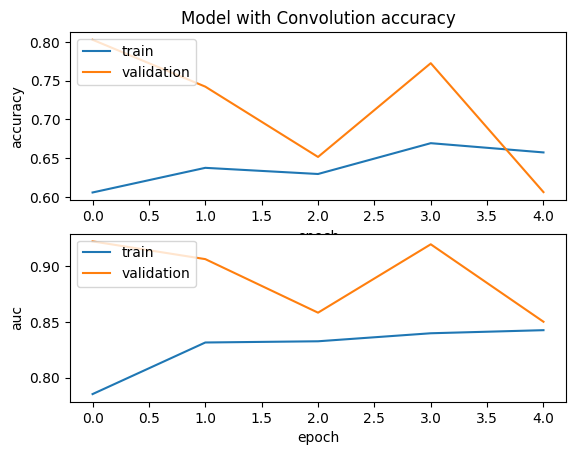

In [81]:
fig = plt.figure()
#plot the accuracy over the epochs
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(model_conv_pooling_history.history['categorical_accuracy'])
ax1.plot(model_conv_pooling_history.history['val_categorical_accuracy'])
ax1.set_title('Model with Convolution and pooling accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(model_conv_pooling_history.history['auc_10'])
ax2.plot(model_conv_pooling_history.history['val_auc_10'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
fig.savefig('/content/drive/MyDrive/model_convolution_pooling_1_accuracy.png')

Over all we have some interesting results, but that which is the most concerning is with the pooling model. The fact that it lowers in AUC (assigning the highest probability to the correct class) decreases as the epochs journeys forward. This is unusual. However we still end result in an 85% AUC.

The best model was the concolution model without pooling. This resulted in both increasing accuracy and AUC over the epochs resulting in an over 90% AUC at the end which is pretty impressive.

There is of course improvements to be made. Perhaps increasing the epochs, adding an EarlyStopping object to prevent over fitting, and also looking at a confusion matrix would give further insights. For now it is a fair effort.